In [1]:
import os
import sys
sys.path.insert(1, "/Users/vsathish/Documents/Quals/dynamics_abstraction/")
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

import torch
import torch.optim as optim
import torch.nn.functional as F
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from models.embedding_model import LearnableEmbedding
from dataloaders.dataloader_pomdp import *


#############################################
# CONSTANTS - Define before running this cell
#############################################

device = torch.device("mps")
BATCH_SIZE = 100
SAMPLES = 1000
PLOT_SAVE_PATH = "/Users/vsathish/Documents/Quals/plots/embedding/"
MODEL_PATH = "/Users/vsathish/Documents/Quals/saved_models/pomdp/oct_25_run_1_embedding.state"

[{'id': 1, 'name': 'Base5 Config 1', 'rows': 5, 'cols': 5, 'walls': [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4)], 'subgoals': [(2, 0), (2, 4)], 'abs_actions': [[[0, 0, 0, 1], [0, 1, 0, 0], [0, 0, 0, 1], [0, 0, 0, 1]], [[1, 0, 0, 0], [0, 0, 0, 1], [0, 0, 0, 1], [0, 0, 1, 0]]]}, {'id': 2, 'name': 'Base5 Config 2', 'rows': 5, 'cols': 5, 'walls': [(0, 0), (0, 3), (0, 4), (1, 0), (1, 3), (1, 4), (2, 3), (2, 4), (3, 0), (3, 3), (3, 4), (4, 0), (4, 3), (4, 4)], 'subgoals': [(2, 0), (4, 2), (0, 2)], 'abs_actions': [[[0, 0, 0, 1], [0, 0, 0, 1], [0, 0, 1, 0], [1, 0, 0, 0]], [[0, 0, 0, 1], [0, 0, 1, 0], [0, 0, 1, 0], [0, 0, 1, 0]]]}]


In [2]:
#####################
# Load Data and Model
#####################

datasets = get_transitions()
print(len(datasets))
data1, data2 = datasets

x1, y1 = batch_data(data1, BATCH_SIZE)
x2, y2 = batch_data(data2, BATCH_SIZE)

print(x2.shape, y1.shape)

x1 = torch.from_numpy(x1).to(device, dtype=torch.float32)
x2 = torch.from_numpy(x2).to(device, dtype=torch.float32)

y1 = torch.from_numpy(y1).to(device, dtype=torch.float32)
y2 = torch.from_numpy(y2).to(device, dtype=torch.float32)

2
here :  1000 25
here :  1000 25
(10, 25, 100, 13) (10, 25, 100, 9)


In [3]:
####################
# Model
####################

model = LearnableEmbedding(device, BATCH_SIZE).to(device)

try:
    model.load_state_dict(torch.load(MODEL_PATH))
    print("################## LOAD SUCCESS #################")

except:
    print("################## NOPE #######################")

print(x1[0].shape, y1[0].shape)
l1, _, higher1 = model(x1[0], y1[0], eval_mode=True) 
l2, _, higher2 = model(x2[0], y2[0], eval_mode=True) 
# l3, _, higher3 = model(x3[0], y3[0], eval_mode=True) 
# l4, _, higher4 = model(x4[0], y4[0], eval_mode=True) 
print(l1, l2)

higher1 = np.array(higher1)
higher2 = np.array(higher2)

# higher3 = np.array(higher3)
# higher4 = np.array(higher4)

################## LOAD SUCCESS #################
torch.Size([25, 100, 13]) torch.Size([25, 100, 9])
42.773003 75.82303


In [4]:
t1 = higher1[-1, :, :]
t2 = higher2[-1, :, :]
print(higher1.shape, higher2.shape)

print(t1.shape, t2.shape)
m1 = np.mean(t1, axis=0)
m2 = np.mean(t2, axis=0)
print(m1, m2)
print(np.square(m1-m2).sum())
# [-0.08769471 -0.09572088  0.10177673  0.15783134] [ 0.0646795   0.06119466 -0.063338   -0.10758822]
# [-0.08248457 -0.09364462  0.09904525  0.15432045] [ 0.06338196  0.060405   -0.06239086 -0.10631932]

(25, 100, 4) (25, 100, 4)
(100, 4) (100, 4)
[-0.06226601 -0.10401359  0.10557623  0.16449113] [ 0.07619003  0.07083875 -0.07332944 -0.12612122]
0.1662062


(50, 4) (50, 2)


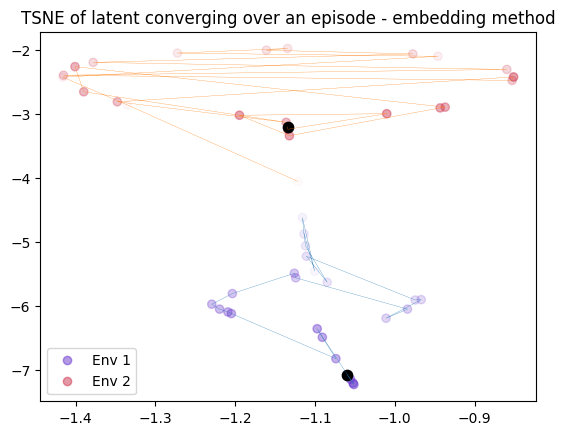

In [5]:
#######################################
# TSNE for Episodic Convergence of S_T
#######################################

t1 = higher1[:, 0, :]
t2 = higher2[:, 0, :]
# t3 = higher3[:, 0, :]
# t4 = higher4[:, 0, :]


episodes = np.concatenate([t1, t2], axis=0)
e_tsne = TSNE(n_components=2, init='pca')
e_embed = e_tsne.fit_transform(episodes)

print(episodes.shape, e_embed.shape)

size = len(e_embed)

p1 = int(size/2)
# p2 = 2 * int(size/4)
# p3 = 3 * int(size/4)

x1 = e_embed[:p1, 0]
x2 = e_embed[p1:, 0]
# x3 = e_embed[p2:p3, 0]
# x4 = e_embed[p3:, 0]

y1 = e_embed[:p1, 1]
y2 = e_embed[p1:, 1]
# y3 = e_embed[p2:p3, 1]
# y4 = e_embed[p3:, 1]


plt.clf()
plt.close()

alpha0 = 0.02

_arr = [x for x in range(len(x1))]
colors1 = []
colors2 = []
# colors3 = []
# colors4 = []

for x in _arr:
    alpha = alpha0 * (x+1)
    c1 = (0.4, 0.2, 0.8, alpha)
    c2 = (0.8, 0.2, 0.3, alpha)
    # c3 = (0.4, 0.8, 0.8, alpha)
    # c4 = (0.2, 0.8, 0.3, alpha)
    colors1.append(c1)
    colors2.append(c2)
    # colors3.append(c3)
    # colors4.append(c4)



plt.scatter(x1, y1, color=colors1, label="Env 1")
plt.scatter(x2, y2, color=colors2, label="Env 2")
# plt.scatter(x3, y3, color=colors3, label="Env 3")
# plt.scatter(x4, y4, color=colors4, label="Env 4")

plt.plot(x1, y1, linewidth=0.2)
plt.plot(x2, y2, linewidth=0.2)
# plt.plot(x3, y3, linewidth=0.2)
# plt.plot(x4, y4, linewidth=0.2)

plt.scatter(x1[-1], y1[-1], color="black", s=55)
plt.scatter(x2[-1], y2[-1], color="black", s=55)
# plt.scatter(x3[-1], y3[-1], color="black", s=55)
# plt.scatter(x4[-1], y4[-1], color="black", s=55)

one = mlines.Line2D([], [], color=c1, marker='o', ls='', label='Env 1')
two = mlines.Line2D([], [], color=c2, marker='o', ls='', label='Env 2')
# three = mlines.Line2D([], [], color=c3, marker='o', ls='', label='Env 3')
# four = mlines.Line2D([], [], color=c4, marker='o', ls='', label='Env 4')
# etc etc
plt.legend(handles=[one, two])

# plt.legend()
plt.title("TSNE of latent converging over an episode - embedding method")
plt.savefig(PLOT_SAVE_PATH+"embedding_episodic_TSNE.png")



(50, 4) (50, 2)


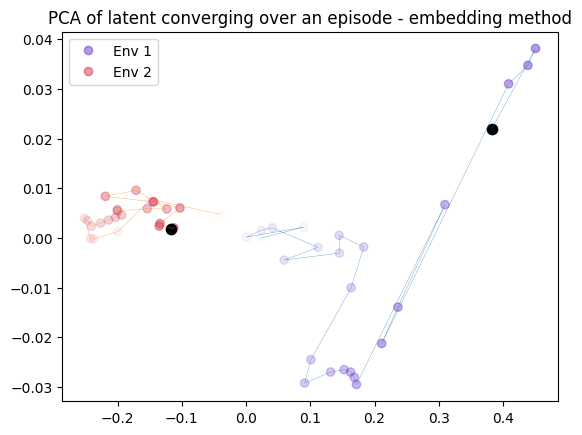

In [6]:
#######################################
# PCA for Episodic Convergence of S_T
#######################################

t1 = higher1[:, 0, :]
t2 = higher2[:, 0, :]

episodes = np.concatenate([t1, t2], axis=0)
e_pca = PCA(n_components=2)
e_embed = e_pca.fit_transform(episodes)

print(episodes.shape, e_embed.shape)

size = len(e_embed)
p1 = int(size/2)
x1 = e_embed[:p1, 0]
x2 = e_embed[p1:, 0]
y1 = e_embed[:p1, 1]
y2 = e_embed[p1:, 1]


plt.clf()
plt.close()

alpha0 = 0.02

_arr = [x for x in range(len(x1))]
colors1 = []
colors2 = []

for x in _arr:
    alpha = alpha0 * (x+1)
    c1 = (0.4, 0.2, 0.8, alpha)
    c2 = (0.8, 0.2, 0.3, alpha)
    colors1.append(c1)
    colors2.append(c2)

plt.scatter(x1, y1, color=colors1, label="Env 1")
plt.scatter(x2, y2, color=colors2, label="Env 2")
plt.plot(x1, y1, linewidth=0.2)
plt.plot(x2, y2, linewidth=0.2)
plt.scatter(x1[-1], y1[-1], color="black", s=55)
plt.scatter(x2[-1], y2[-1], color="black", s=55)


one = mlines.Line2D([], [], color=c1, marker='o', ls='', label='Env 1')
two = mlines.Line2D([], [], color=c2, marker='o', ls='', label='Env 2')

plt.legend(handles=[one, two])

plt.title("PCA of latent converging over an episode - embedding method")
plt.savefig(PLOT_SAVE_PATH+"embedding_episodic_PCA.png")

######### EMBEDDINGS #########
(200, 4) <class 'numpy.ndarray'>
(200, 2)
200


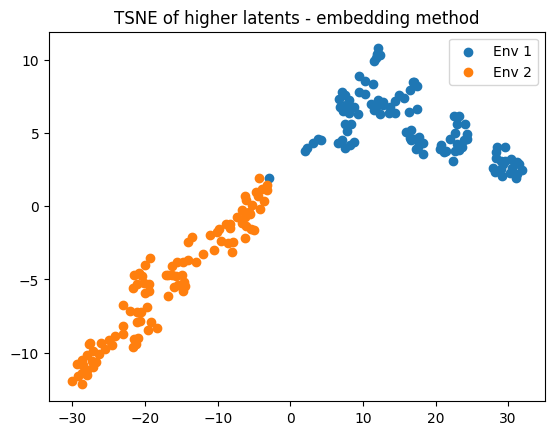

In [7]:
##################
# TSNE Embeddings
##################

h_concat = np.concatenate([higher1[-1], higher2[-1]], axis=0)
print("######### EMBEDDINGS #########")
print(h_concat.shape, type(h_concat))

tsne_ = TSNE(n_components=2, init='pca', perplexity=20)
h_embed = tsne_.fit_transform(h_concat)
print(h_embed.shape)

# Plotting
size = len(h_embed)
p1 = int(size/2)
# p2 = 2 * int(size/4)
# p3 = 3 * int(size/4)


print(size)
x1 = h_embed[:p1, 0]
x2 = h_embed[p1:, 0]
# x3 = h_embed[p2:p3, 0]
# x4 = h_embed[p3:, 0]

y1 = h_embed[:p1, 1]
y2 = h_embed[p1:, 1]
# y3 = h_embed[p2:p3, 1]
# y4 = h_embed[p3:, 1]

plt.clf()
plt.close()

plt.scatter(x1, y1, label="Env 1")
plt.scatter(x2, y2, label="Env 2")
# plt.scatter(x3, y3, label="Env 3")
# plt.scatter(x4, y4, label="Env 4")
plt.legend()
plt.title("TSNE of higher latents - embedding method")
plt.savefig(PLOT_SAVE_PATH+"embedding_state_cloud_TSNE.png")


######### EMBEDDINGS #########
(200, 4) <class 'numpy.ndarray'>


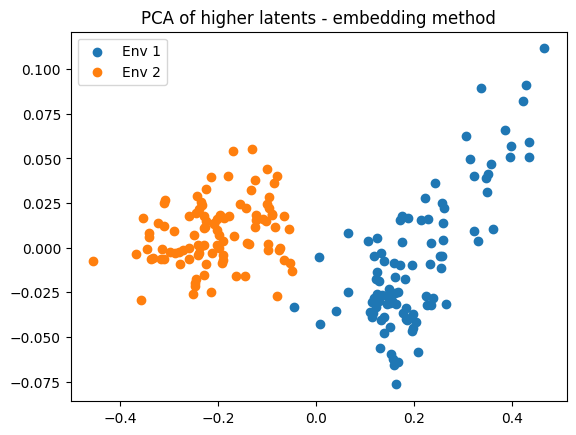

In [8]:
##################
# PCA Embeddings
##################

h_concat = np.concatenate([higher1[-1], higher2[-1]], axis=0)
print("######### EMBEDDINGS #########")
print(h_concat.shape, type(h_concat))

pca_ = PCA(n_components=2)
pca_embed = pca_.fit_transform(h_concat)

size = len(pca_embed)
p1 = int(size/2)
# p2 = 2 * int(size/4)
# p3 = 3 * int(size/4)

x1 = pca_embed[:p1, 0]
x2 = pca_embed[p1:, 0]
# x3 = pca_embed[p2:p3, 0]
# x4 = pca_embed[p3:, 0]

y1 = pca_embed[:p1, 1]
y2 = pca_embed[p1:, 1]
# y3 = pca_embed[p2:p3, 1]
# y4 = pca_embed[p3:, 1]

plt.clf()
plt.close()

plt.scatter(x1, y1, label="Env 1")
plt.scatter(x2, y2, label="Env 2")
# plt.scatter(x3, y3, label="Env 3")
# plt.scatter(x4, y4, label="Env 4")
plt.legend()
plt.title("PCA of higher latents - embedding method")
plt.savefig(PLOT_SAVE_PATH+"embedding_cloud_PCA.png")